# Network test on mnist dataset

This notebook contains the code for training the model using the MNIST dataset stored in .parquet format. This dataset consists of handwritten digit images, which are widely used for training and testing machine learning models in the field of image recognition.

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Data import

In [108]:
def bytes_to_pixels(image):
    image_bytes = image['bytes']
    image_array = np.frombuffer(image_bytes, dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_GRAYSCALE)
    pixel_values = image.flatten()
    return pixel_values

In [109]:
training_data_path = 'train.parquet'
test_data_path = 'test.parquet'

In [110]:
percentage_of_dataset = 1

In [111]:
df1 = pd.read_parquet(training_data_path)

print(df1)

                                                   image  label
0      {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      5
1      {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      0
2      {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      4
3      {'bytes': b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      1
4      {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      9
...                                                  ...    ...
59995  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      8
59996  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      3
59997  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      5
59998  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      6
59999  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      8

[60000 rows x 2 columns]


In [112]:
df1['pixels'] = df1['image'].apply(bytes_to_pixels)

df2 = pd.read_parquet(test_data_path)

df2['pixels'] = df2['image'].apply(bytes_to_pixels)

df = pd.concat([df1[: int(len(df1) * percentage_of_dataset)], df2[: int(len(df2) * percentage_of_dataset)]], ignore_index=True)


print(df[['pixels', 'label']])

                                                  pixels  label
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      5
1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      4
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      1
4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      9
...                                                  ...    ...
69995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      2
69996  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      3
69997  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      4
69998  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      5
69999  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      6

[70000 rows x 2 columns]


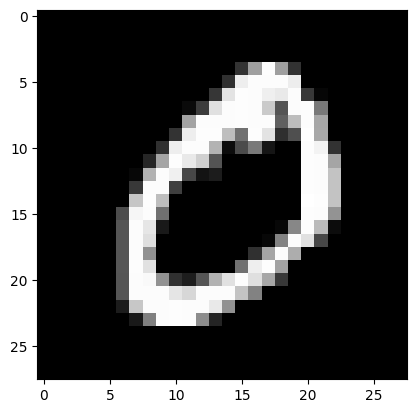

In [113]:
def draw_from_pixels(img):
    first_image_pixels = img
    image_shape = (28, 28)  

    image_array = np.array(first_image_pixels).reshape(image_shape)

    plt.imshow(image_array, cmap='gray')
    plt.show()

draw_from_pixels(df.loc[1, 'pixels'])

## Dataset initialisation

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder


X = df[['pixels', 'label']].copy()

y = (X.pop('label')).astype(int).values.reshape(-1, 1)

X = np.vstack(df['pixels'].values)

train_valid_size = 0.14

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y_train
)


label_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_valid = label_encoder.transform(y_valid)
y_test = label_encoder.transform(y_test)

X_train.shape, y_train.shape

C:\Users\andrz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((51771, 784), (51771, 10))

## Multilayer neural network

In [115]:
import sys
sys.path.append('../../../network') 

from network import Network
from layer import Layer

In [116]:
learning_rate = 1e-3
input_size = X_train.shape[1]
output_size = y_train.shape[1]

early_stopping_patience = 50

model = Network()

model.add_layer(Layer(input_size, 128, activation_function='relu', batch_norm_1d_size=128))
model.add_layer(Layer(128, 128, activation_function='relu', batch_norm_1d_size=128))
model.add_layer(Layer(128, output_size, activation_function='softmax'))

model.early_stopping(early_stopping_patience=early_stopping_patience)

In [117]:
model.fit(X=X_train, y=y_train, learning_rate=learning_rate, epochs=300, verbose=1, batch_size=256)

Epoch 0: loss = 0.09603079612056095
Epoch 10: loss = 0.026659676833170155
Epoch 20: loss = 0.02876126392894679
Epoch 30: loss = 0.021168119690325227
Epoch 40: loss = 0.023797063930470326
Epoch 50: loss = 0.01661161654206659
Epoch 60: loss = 0.018215692500242128
Epoch 70: loss = 0.021363311506441822
Epoch 80: loss = 0.014629811053015099
Epoch 90: loss = 0.01366788356415754
Epoch 100: loss = 0.013409051399428941
Epoch 110: loss = 0.01849297858718045
Epoch 120: loss = 0.011292036081976464
Epoch 130: loss = 0.01421645322670993
Epoch 140: loss = 0.012632554905241282
Epoch 150: loss = 0.015267234552162407
Epoch 160: loss = 0.011886963744181104
Epoch 170: loss = 0.01230418574105194
Epoch 180: loss = 0.011334530914977142
Epoch 190: loss = 0.011543141913426435
Epoch 200: loss = 0.010272160089625466
Epoch 210: loss = 0.010469181588147804
Epoch 220: loss = 0.010113770251629243
Epoch 230: loss = 0.010013327924899949
Epoch 240: loss = 0.010465318421510111
Epoch 250: loss = 0.010932761584670958
Epoc

In [118]:
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


y_pred_test_score = model.predict(X_test)

auroc = roc_auc_score(y_test, y_pred_test_score)


y_true_flat = np.argmax(y_test, axis=1)
y_pred_flat = np.argmax(y_pred_test_score, axis=1)

accuracy = accuracy_score(y_true_flat, y_pred_flat)
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
classification_rep = classification_report(y_true_flat, y_pred_flat)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
print(f"AUROC: {100 * auroc:.2f}%")

Accuracy: 0.9464340373431283
Confusion Matrix:
[[ 945    0    0    2    2    3    4    3    5    2]
 [   0 1040    5    3    1   15    0    9   27    3]
 [  13    1  928    6    5    2    4    6   11    3]
 [   2    0   12  902    0   45    4    8   13   14]
 [   0    0    7    0  894    1    7    6    1   39]
 [   6    0    2    3    0  853   10    1    5    4]
 [   9    2    2    0    9    4  927    0   10    0]
 [   2    0   14    4    5    0    0  991    1    4]
 [  19    2    5    7    2   11    3    7  886   14]
 [  10    1    2    9   12    4    0   21    5  910]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       966
           1       0.99      0.94      0.97      1103
           2       0.95      0.95      0.95       979
           3       0.96      0.90      0.93      1000
           4       0.96      0.94      0.95       955
           5       0.91      0.96      0.94       884
           6       0

### Save the model

In [128]:
# path = '../../models/mnist1model.pickle'
# model.save(path)

## Tests on self drawn numbers

In [120]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    img_resized = cv2.resize(img, (28, 28))
    
    img_normalized = img_resized.astype('float32') / 255.0

    img_input = img_normalized.flatten().reshape(1, -1)
    
    return img_input

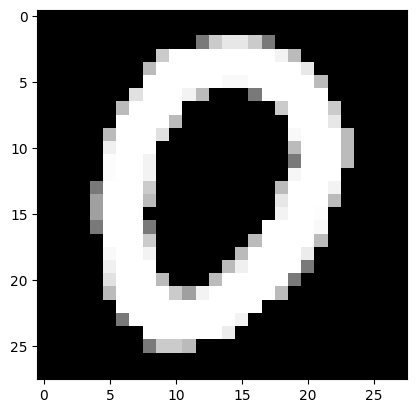

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [125]:
image_path = 'my_data/01.png'
number_px = preprocess_image(image_path)

draw_from_pixels(number_px)

number_pred = model.predict(number_px)
print(np.round(number_pred, 2))

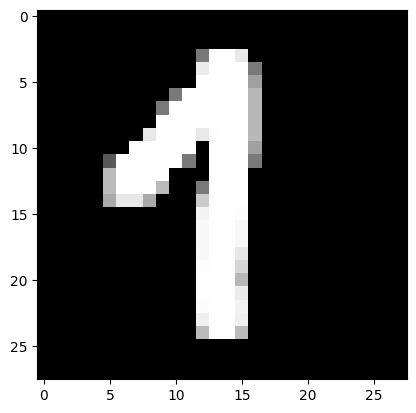

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [124]:
image_path = 'my_data/11.png'
number_px = preprocess_image(image_path)

draw_from_pixels(number_px)

number_pred = model.predict(number_px)
print(np.round(number_pred, decimals=0))

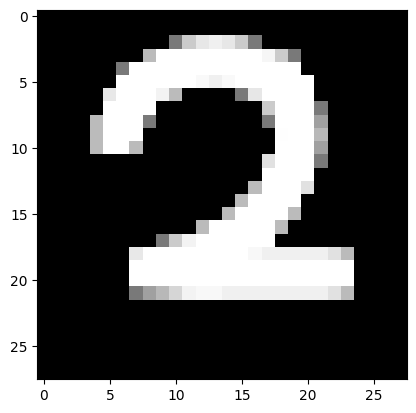

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [126]:
image_path = 'my_data/21.png'
number_px = preprocess_image(image_path)

draw_from_pixels(number_px)

number_pred = model.predict(number_px)
print(number_pred)